In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using ProgressMeter
using Interpolations
using Distributions

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [3]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

routine_spectrum (generic function with 1 method)

### Configuration setup

In [4]:
#
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset,
             U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.2, 2.2, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

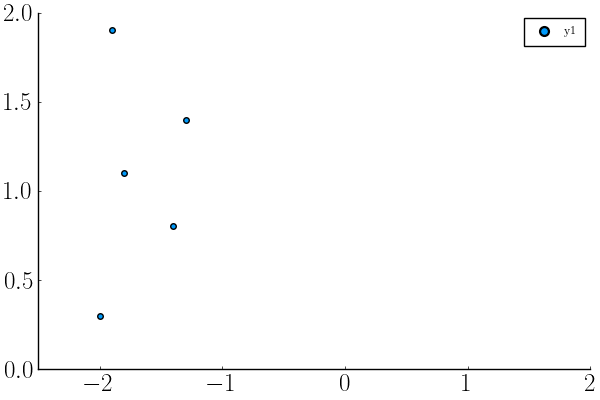

In [5]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [6]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = vcat(blobs₊, blobs₋)

# data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/example2/data/data_vortex.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-2.018587306805637, 0.3469573514039377, 0.45880001794294045, -1.8218225076346501, 1.8957320291019035, 0.3768744289098014, -1.8102180547912552, 1.0615219698346763, 0.26918155979815017, -1.273480600181778, 1.3996292681183138, 0.39099049767578464, -1.3586001809001103, 0.7834839950529129, 0.2327616928563841], [-2.018587306805637 -2.0172169502893196 … 12.59044061465947 12.591482987090947; 0.3469573514039377 0.3469042736866317 … 1.1421505993204804 1.1421716017979275; … ; 0.7834839950529129 0.7835958875071971 … 1.5055566951364918 1.5054079889283538; 0.2327616928563841 0.2327616928563841 … 0.2327616928563841 0.2327616928563841], [-0.524522656873511 -0.5090575008179341 … -0.4727590518054783 -0.4724508529842126; -0.5379397508961893 -0.5208171476572888 … -0.5119750022574816 -0.51414802719

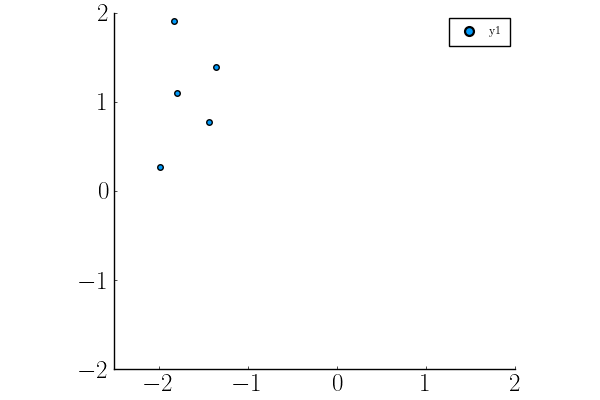

In [7]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

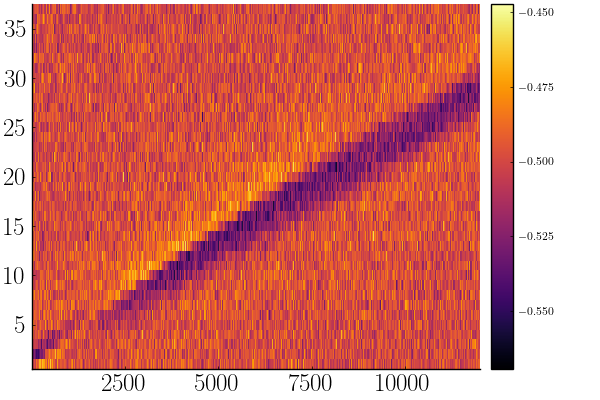

In [8]:
heatmap(data.yt)

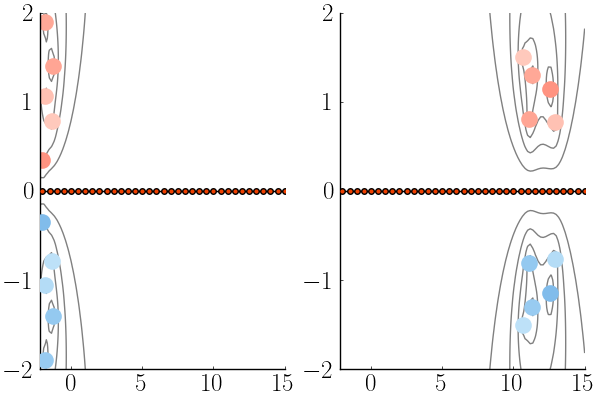

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [9]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

### Setup the sequential filter

In [10]:
config = deepcopy(config_data)
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [50]:
function spectrumCxCy(X, tsnap, Nx, Ny)
    Ne = size(X[1],2)
    Cx = zeros(Nx, Nx)
    Cy = zeros(Ny, Ny)


    nsnap = ceil(Int64, tsnap/0.1)+1
    Xcxcy = deepcopy(vcat(zeros(Ny, Ne), X[nsnap]))

    ϵX = config.ϵX
    ϵΓ = config.ϵΓ
    β = config.β
    ϵY = config.ϵY

    ϵx = RecipeInflation([ϵX; ϵΓ])
    ϵmul = MultiplicativeInflation(β)

    # Perform state inflation
    ϵmul(Xcxcy, Ny+1, Ny+Nx)
    ϵx(Xcxcy, Ny, Nx, config)
    Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
    # Dx = I
    Dϵ = config.ϵY*I
    freestream = Freestream(config.U)
    # Dϵ = I
    
    @inbounds for i=1:Ne
        J = analytical_jacobian_pressure(config.ss, vcat(state_to_lagrange(Xcxcy[Ny+1:end,i], config)...), 
                                         freestream, tf)
        Ji = J[:,1:3*config.Nv]
        Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
        Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'
    end
    Px, σx = svd(cov(Xcxcy[Ny+1:Ny+Nx,:]'))
    
    Vx, Λx = svd(Symmetric(Cx))
    Vy, Λy = svd(Symmetric(Cy))
    
    

    Λx = sort(abs.(Λx); rev = true)
    Λy = sort(abs.(Λy); rev = true)
    
    
    
    return Px, σx, Λx, Vx, Λy, Vy
end

spectrumCxCy (generic function with 1 method)

In [45]:
Ne = 1000

1000

In [46]:
# Xf = load("/media/mat/HDD/Paper Potential Flow/Example 2/ensemble_Ne_"*string(Ne)*".jld")["Xf"]

In [47]:
# save("/media/mat/HDD/Paper Potential Flow/Example 2/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld", "Xf", Xf[1:100:end])

Xf = load("/media/mat/HDD/Paper Potential Flow/Example 2/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld")["Xf"];

In [48]:
Nx = 3*config.Nv
Ny = length(config.ss);

In [49]:
Px, σx, Λx, Vx, Λy, Vy = spectrumCxCy(Xf, 0.0, Nx, Ny)

(size(X), size(X[nsnap])) = ((121,), (15, 1000))


([-0.0031956110572919152 0.028058873937625933 … -0.10545461725547346 -0.04587908524633442; -0.003110663303940035 0.0061637308323071755 … 0.5877190281379955 -0.2869206650971515; … ; -0.014010590906256544 0.0062319354190873205 … -0.09815411755574992 0.3616283120091361; -0.5582908590068442 -0.653159421646911 … -0.0029303033695233446 -0.00292749123212073], [0.011500651137886326, 0.010569335389707836, 0.010119327208232375, 0.00932080248361635, 0.009154962384785907, 0.0016287499086957806, 0.0015276000142040648, 0.001458873661213084, 0.001405281104577982, 0.0013855881529011272, 0.001354802335477467, 0.0013303075212709574, 0.0012644277887887403, 0.0012004571324637759, 0.0011513228803078051], [1.415326224250366, 0.3867843100159049, 0.0908422278543343, 0.03632086952803054, 0.014978814713259216, 0.004936474462831121, 0.003035999043159455, 0.0019309166003486304, 0.000758973594296502, 0.0004516882481331499, 0.0004022230448941795, 0.0003264469963835558, 0.0002377934596183118, 0.0001146981477128802, 

In [27]:
Λxtab = Vector{Float64}[]
Λytab = Vector{Float64}[]

Nx = 3*config.Nv

tlist = collect(0.0:0.1:12.0)

@showprogress for tsnap in tlist   
    nsnap = ceil(Int64, tsnap/0.1)+1
    Px, σx, Λx, Vx, Λy, Vy = spectrumCxCy(Xf[nsnap], tsnap, Nx, Ny)
    
    push!(Λxtab, deepcopy(Λx))
    push!(Λytab, deepcopy(Λy))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


In [18]:
q5_Λx = map(x-> quantile(x, 0.05), eachcol(hcat(Λxtab...)'))
q25_Λx = map(x-> quantile(x, 0.25), eachcol(hcat(Λxtab...)'))
q50_Λx = map(x-> quantile(x, 0.50), eachcol(hcat(Λxtab...)'))
q75_Λx = map(x-> quantile(x, 0.75), eachcol(hcat(Λxtab...)'))
q95_Λx = map(x-> quantile(x, 0.95), eachcol(hcat(Λxtab...)'))


q5_Ex  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q25_Ex = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q50_Ex = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q75_Ex = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q95_Ex = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))


q5_deltaΛx = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q25_deltaΛx = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q50_deltaΛx = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q75_deltaΛx = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q95_deltaΛx = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))

q5_Λy = map(x-> quantile(x, 0.05), eachcol(hcat(Λytab...)'))
q25_Λy = map(x-> quantile(x, 0.25), eachcol(hcat(Λytab...)'))
q50_Λy = map(x-> quantile(x, 0.50), eachcol(hcat(Λytab...)'))
q75_Λy = map(x-> quantile(x, 0.75), eachcol(hcat(Λytab...)'))
q95_Λy = map(x-> quantile(x, 0.95), eachcol(hcat(Λytab...)'))


q5_Ey  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q25_Ey = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q50_Ey = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q75_Ey = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q95_Ey = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))


q5_deltaΛy = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q25_deltaΛy = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q50_deltaΛy = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q75_deltaΛy = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q95_deltaΛy = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'));

In [32]:
Ny

37

In [30]:
q50_Ex

15-element Vector{Float64}:
 0.8190370259716026
 0.9288635511350871
 0.9694436548998095
 0.9875349677999892
 0.9943276696242392
 0.9979824608635414
 0.9986853916982439
 0.9991644554489838
 0.9994633883158152
 0.9996943128208743
 0.9998027869463909
 0.9998909219060208
 0.9999564336319491
 0.9999909018616435
 1.0

In [31]:
q50_Ey

37-element Vector{Float64}:
 0.8194685251193776
 0.9302860263966526
 0.9714567060462319
 0.9893643373303602
 0.9961803326337073
 0.9990966123537671
 0.9997270647519102
 0.999890697458649
 0.9999844005559435
 0.9999979015383049
 0.9999998913864953
 0.9999999869030729
 0.9999999990648593
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

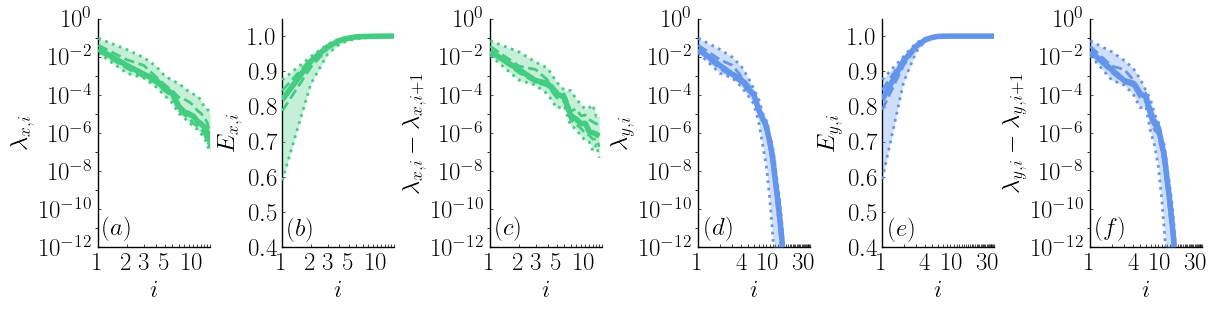

In [230]:
c_cx = colorant"tomato"
c_cx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"

ylist = Float64[]
yliststring = String[]
for i=0:-2:-12
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end

Xxlist = Float64[]
Xxliststring = String[]
for i=1:Nx
    push!(Xxlist, i)
    if i ∈ [1;2;3;5; 10]
        push!(Xxliststring, latexstring("$i"))
    else
        push!(Xxliststring, "")
    end
end

Yxlist = Float64[]
Yxliststring = String[]
for i=1:Ny
    push!(Yxlist, i)
    if i ∈ [1; 4; 10; 30]
        push!(Yxliststring, latexstring("$i"))
    else
        push!(Yxliststring, "")
    end
end


# Yxlist = [10; 20; 30]
# Yxliststring = string.(Yxlist)


plt = plot(layout = grid(1,6), xlims = (1, Inf), legend = false, size = (1200, 300))


# Cx eigenvalues
plot!(plt[1,1], ylims = (10.0^(-12), 10.0^(-1)), yscale = :log10, xscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{x, i}", xticks = (Xxlist, Xxliststring))


plot!(plt[1,1], 1:Nx, q5_Λx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,1], 1:Nx, q25_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q50_Λx, linewidth = 4, color = c_cx)
plot!(plt[1,1], 1:Nx, q75_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q95_Λx, linewidth = 2, linestyle = :dot, color = c_cx)


plot!(plt[1,1], 1:Nx, [q50_Λx q50_Λx], linewidth = 0.0,
      fillrange = [q5_Λx q95_Λx], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,1], 1.6, 10.0^(-11), L"(a)")

# Cx cumulative energy
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_{x, i}", ylim = (0.4, 1.05), xlims = (1, Inf),
     xticks = (Xxlist, Xxliststring), xscale = :log10)


plot!(plt[1,2], 1:Nx, q5_Ex, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,2], 1:Nx, q25_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q50_Ex, linewidth = 4, color = c_cx)
plot!(plt[1,2], 1:Nx, q75_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q95_Ex, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,2], 1:Nx, [q50_Ex q50_Ex], linewidth = 0.0,
      fillrange = [q5_Ex q95_Ex], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,2], 1.6, 0.45, L"(b)")


# Cx Spectral gap 
plot!(plt[1,3], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, 
      yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{x, i} - \lambda_{x, i+1}", xticks = (Xxlist, Xxliststring))



plot!(plt[1,3], 1:Nx-1, q5_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q25_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q50_deltaΛx, linewidth = 4, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q75_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q95_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,3], 1:Nx-1, [q50_deltaΛx q50_deltaΛx], linewidth = 0.0,
      fillrange = [q5_deltaΛx q95_deltaΛx], alpha = 0.3, color = c_cx,
      label = "")

annotate!(plt[1,3], 1.6, 10.0^(-11), L"(c)")

# Cy eigenvalues
plot!(plt[1,4], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, yticks = (ylist, yliststring),
              xlabel = L"i", ylabel = L"\lambda_{y, i}", xticks = (Yxlist, Yxliststring))


plot!(plt[1,4], 1:Ny, q5_Λy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,4], 1:Ny, q25_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q50_Λy, linewidth = 4, color = c_cy)
plot!(plt[1,4], 1:Ny, q75_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q95_Λy, linewidth = 2, linestyle = :dot, color = c_cy)


plot!(plt[1,4], 1:Ny, [q50_Λy q50_Λy], linewidth = 0.0,
      fillrange = [q5_Λy q95_Λy], alpha = 0.3, color = c_cy,
      label = "") 


annotate!(plt[1,4], 2, 10.0^(-11), L"(d)")

# Cy cumulative energy
plot!(plt[1,5], xlabel = L"i", ylabel = L"E_{y, i}", xscale = :log10,
      ylim = (0.4, 1.05), xlims = (1, Inf), 
      xticks = (Yxlist, Yxliststring))


plot!(plt[1,5], 1:Ny, q5_Ey, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,5], 1:Ny, q25_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q50_Ey, linewidth = 4, color = c_cy)
plot!(plt[1,5], 1:Ny, q75_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q95_Ey, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,5], 1:Ny, [q50_Ey q50_Ey], linewidth = 0.0,
      fillrange = [q5_Ey q95_Ey], alpha = 0.3, color = c_cy,
      label = "") 

annotate!(plt[1,5], 2, 0.45, L"(e)")

# Cy Spectral gap 
plot!(plt[1,6], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{y, i} - \lambda_{y, i+1}", xticks = (Yxlist, Yxliststring))



plot!(plt[1,6], q5_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,6], q25_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q50_deltaΛy, linewidth = 4, color = c_cy)
plot!(plt[1,6], q75_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q95_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,6], [q50_deltaΛy q50_deltaΛy], linewidth = 0.0,
      fillrange = [q5_deltaΛy q95_deltaΛy], alpha = 0.3, color = c_cy,
      label = "")

annotate!(plt[1,6], 2, 10.0^(-11), L"(f)")


savefig("example2_energy_spectrum.pdf")

In [281]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)


tsnap = 1.0

nsnap = ceil(Int64, tsnap/0.1)+1

Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xf[nsnap]))
h(x, t) = measure_state(x, t, config; withfreestream = true)

ϵX = config.ϵX
ϵΓ = config.ϵΓ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ])
ϵmul = MultiplicativeInflation(β)
ϵy = AdditiveInflation(zeros(Ny), ϵY)
# Perform state inflation
ϵmul(Xcxcy, Ny+1, Ny+Nx)
ϵx(Xcxcy, Ny, Nx, config)
@showprogress for i=1:Ne
    observe(h, Xcxcy, tsnap, Ny, Nx)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


In [282]:
Σxx = cov(Xcxcy[Ny+1:Ny+Nx,:]')
Σyy = cov(Xcxcy[1:Ny,:]')
Σxy = 1/(Ne-1)*(Xcxcy[Ny+1:Ny+Nx,:] .- mean(Xcxcy[Ny+1:Ny+Nx,:]; dims = 2)[:,1])*(Xcxcy[1:Ny,:] .- mean(Xcxcy[1:Ny,:]; dims = 2)[:,1])';

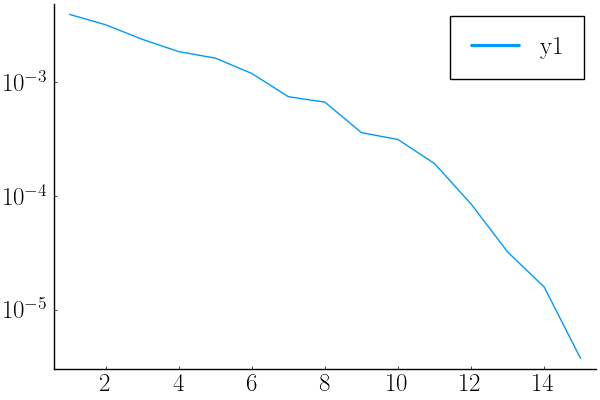

In [283]:
plot(svd(cov(Xcxcy[Ny+1:Ny+Nx,:]')).S, yscale = :log10)

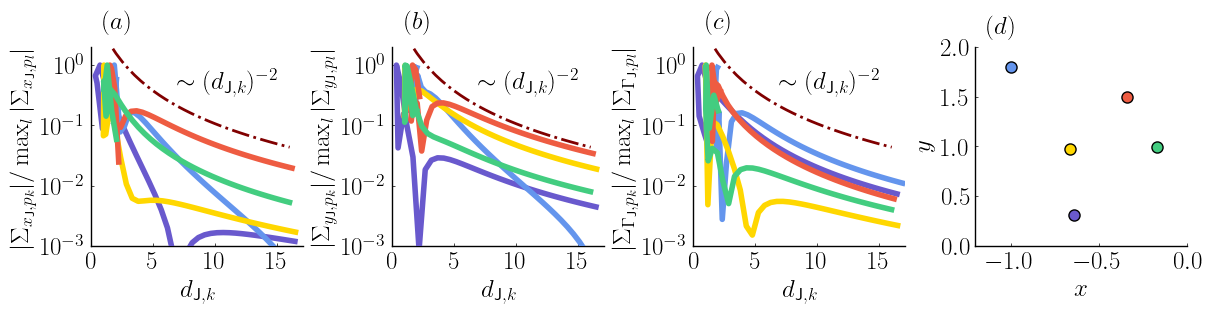

In [290]:
blobs = state_to_lagrange(mean(Xcxcy[Ny+1:Ny+Nx,:]; dims = 2)[:,1], config)[1][1:config.Nv]

# c_Σxy = palette([palette(:viridis)[1], palette(:blackbody)[end], colorant"goldenrod3"], 15)
# c_Σxy = palette(:okabe_ito)
c_Σxy = [colorant"slateblue3";
          colorant"cornflowerblue";
          colorant"gold";
          colorant"tomato2";
          colorant"seagreen3"; 
          colorant"maroon"]
c_σx = colorant"seagreen3"
c_σxy = colorant"tomato"
c_σy = colorant"cornflowerblue"

xlist = Float64[]
xliststring = String[]
for i=-2:1:2
    xi = tsnap+0.5*i
    push!(xlist, xi)
    push!(xliststring, latexstring("$xi"))
    
end

ylist = Float64[]
yliststring = String[]
for i=0:-1:-3
    push!(ylist, (10.0)^i)
    push!(yliststring, latexstring("10^{$i}"))
end

plt = plot(layout = grid(1,4), size = (1200, 300))

# ylabelstring = ["\widehat{\Sigma}_{x_i, y_i}"] 
for i=1:3
    plot!(plt[1,i], yticks = (ylist, yliststring), ylims = (10.0^(-3), 2*10.0^0), 
                    xlabel = L"d_{\mathsf{J}, k}", xlims = (0, Inf))
#           xlabel = string("Re")*L"(\xi_k)")
end
plot!(plt[1,1], ylabel = L"|\Sigma_{x_{\mathsf{J}},p_k}|/\max_l|\Sigma_{x_{\mathsf{J}},p_l}|")
plot!(plt[1,2], ylabel = L"|\Sigma_{y_{\mathsf{J}},p_k}|/\max_l|\Sigma_{y_{\mathsf{J}},p_l}|")
plot!(plt[1,3], ylabel = L"|\Sigma_{\Gamma_{\mathsf{J}},p_k}|/\max_l|\Sigma_{\Gamma_{\mathsf{J}},p_l}|")


plot!(plt[1,4], xlabel = L"x", ylabel = L"y",
    ylims = (0.0, 2.0), xlims = (-1.2, 0.0), xticks = tsnap-2:0.5:tsnap+1)

annotationlist = [L"(a)"; L"(b)"; L"(c)"; L"(d)"; L"(e)"; L"(f)"]
for i=1:3
    zc = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
    vline!(plt[1,i], [real(zc)], linewidth = 2, linestyle = :dash, color = :grey47)
    plot!(plt[1,i], real.(sensors), 12 ./(abs.(sensors .- zc)).^2, 
          linestyle = :dashdot,linewidth = 2, color = c_Σxy[6])
    annotate!(plt[1,i], 2.2, 5.2, annotationlist[i], topmargin = 40*Plots.px)
    annotate!(plt[1,i], 11, 0.5, L"\tiny{\sim (d_{\mathsf{J}, k})^{-2}}")

end

annotate!(plt[1,4], -1.05, 2.2, annotationlist[4])


for (i, bi) in enumerate(blobs)
    dij = abs.(bi.z .- sensors)#.*sign.(real(sensors).-real(bi.z))
    
    plot!(plt[1,1], dij, abs.(Σxy[3*(i-1)+1,:])./maximum(abs.(Σxy[3*(i-1)+1,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    plot!(plt[1,2], dij, abs.(Σxy[3*(i-1)+2,:])./maximum(abs.(Σxy[3*(i-1)+2,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    plot!(plt[1,3], dij, abs.(Σxy[3*(i-1)+3,:])./maximum(abs.(Σxy[3*(i-1)+3,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    
    scatter!(plt[1,4], [real(bi.z)], [imag(bi.z)], markersize = 8, color = c_Σxy[i], legend = false)
end

plt

savefig("cross_correlation.pdf")

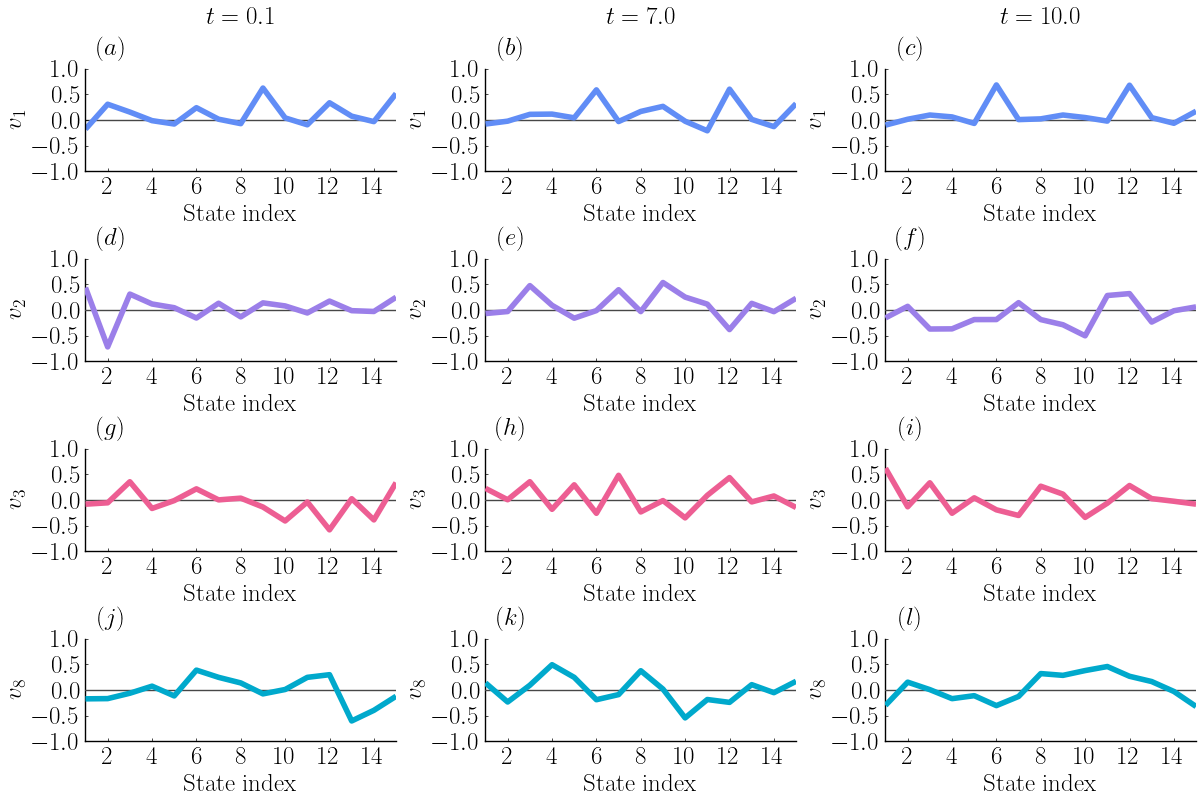

In [240]:
tsnaptab= [0.1; 7.0; 10.0]

plt = plot(layout = grid(4,3), xlabel = "State index", legend = false, 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (1200, 800), grid = false)

indexlist = ["(a)"; "(b)"; "(c)"; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3; 8]
counter = 0
signflip = [1 1 1; 1 -1 -1; 1  1 -1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, Vx, _, _  = spectrumCxCy(Xf, ti)
        ni = ceil(Int64, ti/0.1)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        counter += 1
        hline!(plt[j,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid)
        plot!(plt[j,i], signflip[j,i]*Vx[:,rj], color = clist[j],
              linestyle = :solid, linewidth = 4, legend = false, ylabel = latexstring("v_{$rj}"), 
              topmargin = 20*Plots.px) 
        annotate!(plt[j,i], 2.2, 1.4, latexstring(indexlist[counter]))
    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 2.0, latexstring("t = $ti"), topmargin = 60*Plots.px)
end
plt
# savefig("V_eigenvector.pdf")

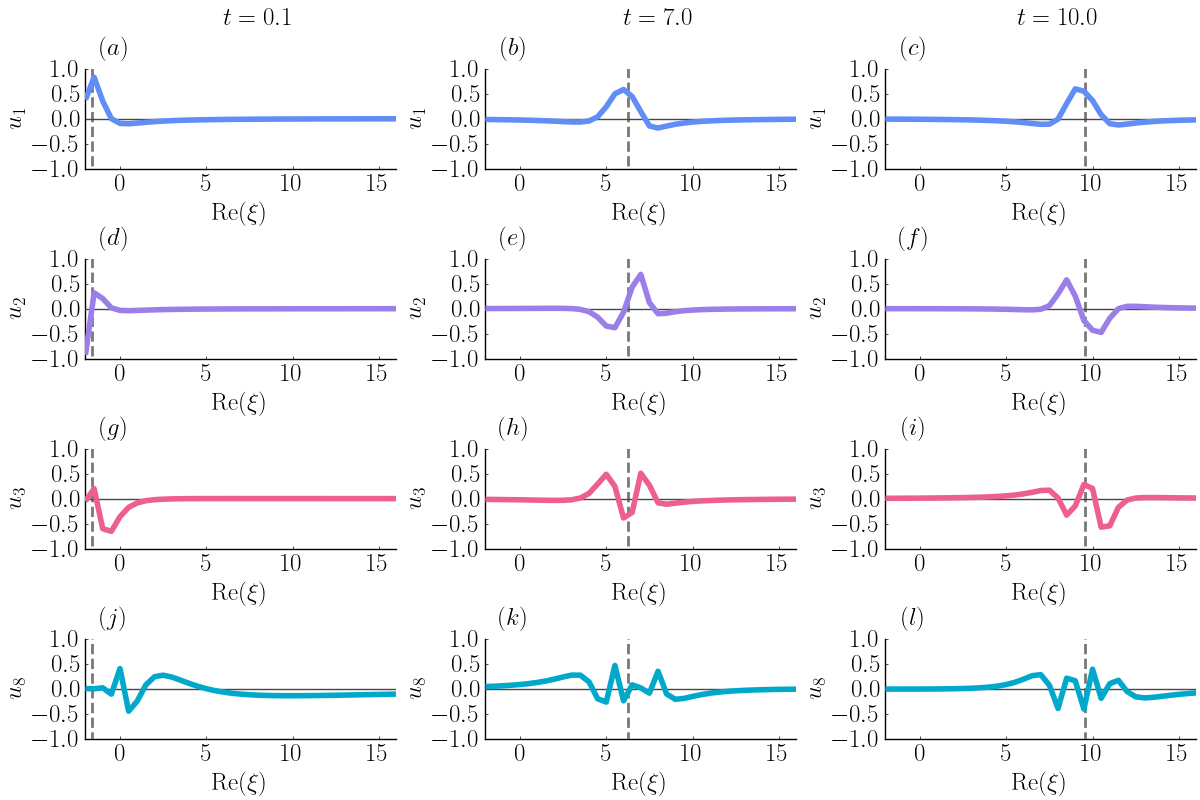

In [51]:
tsnaptab= [0.1; 7.0; 10.0]

plt = plot(layout = grid(4,3), xlabel = string("Re")*L"(\xi)", legend = false, 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (1200, 800), grid = false)

clist = [theme_palette(:auto)[13]; theme_palette(:auto)[12];  theme_palette(:auto)[7];  theme_palette(:auto)[11]]

indexlist = ["(a)"; "(b)"; "(c)"; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3; 8]
counter = 0
signflip = [1 1 1; 1 -1 1; 1  1 1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, _, _, Vy  = spectrumCxCy(Xf, ti, Nx, Ny)
        ni = ceil(Int64, ti/0.1)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        counter += 1
        vline!(plt[j,i], [real(zci)], linewidth = 2, linestyle = :dash, color = :grey47)
        hline!(plt[j,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid)
        plot!(plt[j,i], real(sensors), signflip[j,i]*Vy[:,rj], color = clist[j],
              linestyle = :solid, linewidth = 4, legend = false, ylabel = latexstring("u_{$rj}"), 
              topmargin = 20*Plots.px) 
        annotate!(plt[j,i], -0.3, 1.4, latexstring(indexlist[counter]))
    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 2.0, latexstring("t = $ti"), topmargin = 60*Plots.px)
end
plt
# savefig("U_eigenvector.pdf")

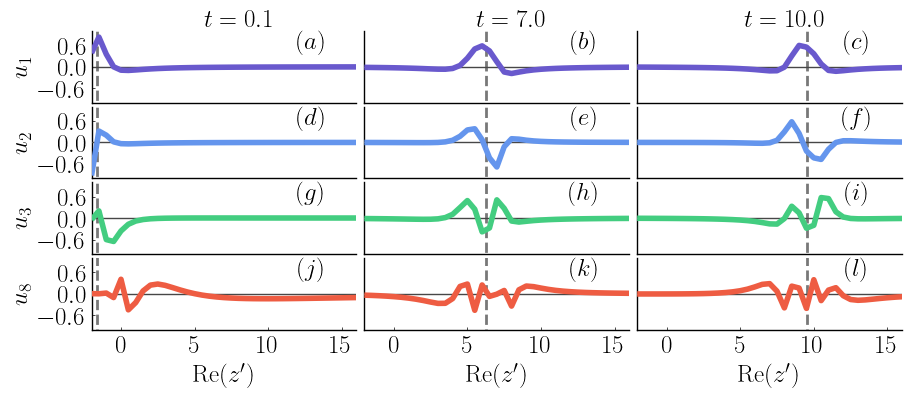

In [53]:
tsnaptab= [0.1; 7.0; 10.0]

# , xlabel = string("Re")*L"(\xi)"

ylist = Float64[-0.6; 0.0; 0.6]
yliststring = String[latexstring("-0.6"); latexstring("0.0"); latexstring("0.6")]

plt = plot(layout = grid(4,3), legend = false, 
           xticks = false, yticks = false, 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (900, 400), grid = false)

clist = [colorant"slateblue3";
         colorant"cornflowerblue";
         colorant"seagreen3"; 
         colorant"tomato2";
         colorant"gold";
         colorant"maroon"]

indexlist = [L"\scriptsize{(a)}"; "(b)"; "(c)"; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3; 8]
counter = 0
signflip = [1 1 1; 1 1 1; 1  1 -1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, _, _, Vy  = spectrumCxCy(Xf, ti, Nx, Ny)
        ni = ceil(Int64, ti/0.1)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        counter += 1
        vline!(plt[j,i], [real(zci)], linewidth = 2, linestyle = :dash, color = :grey47)
        hline!(plt[j,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid)
        plot!(plt[j,i], real(sensors), signflip[j,i]*Vy[:,rj], color = clist[j],
              linestyle = :solid, linewidth = 4, legend = false, 
              topmargin = 0*Plots.px) 
        annotate!(plt[j,i], 13, 0.7, latexstring(indexlist[counter]))
        if i == 1
           plot!(plt[j,1], yticks = (ylist, yliststring)) 
        end
        
        if j == length(rlist)
           plot!(plt[j,i], xticks = true, xlabel = string("Re")*L"(z^\prime)")
        end
    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 1.3, latexstring("t = $ti"), topmargin = 40*Plots.px)    
end

for (j, rj) in enumerate(rlist) 
    plot!(plt[j,1], ylabel = latexstring("u_{$rj}"))
end
plt
savefig("U_eigenvector2.pdf")

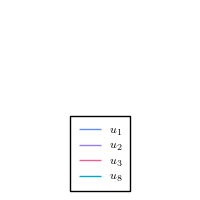

In [33]:
plt = plot(xlim = (0.1, 0.2), ylim = (0.0, 0.1), xaxis = false, yaxis = false, legend = :bottom, 
           size = (200, 200), legendfont = font("CMU Serif", 20))

for (i, ri) in enumerate(rlist)
    plot!(plt, zeros(2), linewidth = 3, label = label = latexstring("u_{$ri}"), color = clist[i])
end
plt

# savefig("legend_U_eigenvector.pdf")